# Browning trends XGBoost model - local run with loop

### Peter R.
#### 2025-03-11

Here we use BFAST breaks derived from 20-years of forest EVI (enhanced vegetation index) time series (ts) observations. These breaks were produced using a BFAST *h* parameter equal to 0.05 (or ~ 5% of the ts) and used in Extreme Gradient Boosting (XGBoost) models. The response variable is (forest EVI) magnitude of break and predictors are forest and climate-related variables. The code below is for negative breaks only.  

The data used here were produced with R and DuckDb. Climate variables were shortlisted using variation inflation factor (VIF). The code for putting the data frame together is not shown here.

An important number of Bfast breaks had wide 95% confidence intervals (CIs) associated with the time of break. These 95% CIs  ranged from about 1 month to 80+ months. These records provide poor quality matching with yearly forest, climate and disturbance data. For this reason, we decided to test XGB models (boosted regression trees, BRT) with subsets of data with narrow 95% CIs. The following XGB models and dataframe subsets are run:

- Dataframe3 (df3): Records with 95% CIs shorter than 3 16-days data points (48 days or about 1.5 months)

- Dataframe6 (df6): Records with 95% CIs shorter than 6 16-days data points (96 days or about 3 months)

- Dataframe9 (df9): Records with 95% CIs shorter than 9 16-days data points (144 days or about 5 months)

- Dataframe23 (df23): Records with 95% CIS shorter than 23 16-days data points (368 days or about 1 year)

This notebook has three main parts. The first one runs XGBoost with different subsets of the data. The second part does the same but removes records matched with disturbance data. The last part, runs the best model and creates figures.

Some points to have in mind:

- Some of the XGBoost parameter values used below were obtained by using RandomizedSearchCV available in Scikit-learn. This step  is not shown here.

- Given that Global Forest Change (Hansen *et al.* 2013) had the most matches (spatiotemporal overlap) with break data we used this data source to filter out matched breaks. This was done so that variation by forest and climate-related predictors can be better tunned in.


### Setup

In [1]:
# Peter R.
# XGBoost script

#Here I am using a loop to run several models at a time

import os
import time

import pandas as pd
from numpy import nan
import xgboost as xgb
from numpy import absolute
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# for feature importance plots
from matplotlib import pyplot
import matplotlib.pyplot as plt
import numpy as np

#for dependency plots
from sklearn.inspection import PartialDependenceDisplay

#start = time.time()

# Get the current working directory
cwd = os.getcwd()

#print(cwd)

# DRAC directory
#os.chdir("/home/georod/projects/def-mfortin/georod/scripts/github/forc_trends/models/xgboost")
# Win directory
os.chdir(r'C:\Users\Peter R\github\forc_stpa\models\xgboost\exploratory')


print("XGB version:", xgb.__version__)
print("negative breaks")


# Windows
df1 = pd.read_csv(r'.\data\df2_trends_p1_vars_browning_v1.csv', skipinitialspace=True)
# DRAC
#df1 = pd.read_csv(r'./data/forest_evi_breaks_positive_v2.csv', skipinitialspace=True)
#df1.head()


df11 = pd.get_dummies(df1, columns=['for_pro'], dtype=float)



XGB version: 1.7.6
negative breaks


In [2]:
# Notes
# - Here I am reorganizing the columns so that all dfs have the outcome as the first column
#Df0: all rows (including nulls)
df0 = df11.loc[(df11['for_age_2003'] >= 0) & (df11['elev'] > 0)]

# Df3:
#df3 = df11.dropna()
#df3 = df11.loc[(df11['for_age_2003'] >= 0) & (df11['elev'] > 0)]
#df3.describe()


#dfall = [df0, df3, df6, df9, df23]
#dfall = [df0, df3] # df0 & df3 are the same df so far
dfall = [df0]


#Df0: all rows
#dfall = [df11]


In [3]:
print(dfall[0].describe())  # 10127

                 pix     year  for_age_2003  for_con_2003          elev  \
count   10127.000000  10127.0  10127.000000  10127.000000  10127.000000   
mean   237167.221191   2003.0     90.859603     34.461823    375.535490   
std    138216.246576      0.0     15.503036     19.293782     85.656141   
min       613.000000   2003.0     40.004000      2.675000    121.629000   
25%    124192.500000   2003.0     79.762500     18.704000    307.491000   
50%    224723.000000   2003.0     88.362000     29.259000    388.362000   
75%    356393.000000   2003.0    100.386000     48.282000    446.374000   
max    493323.000000   2003.0    170.139000     88.409000    543.641000   

       p1_trend  p1_trend_slope  trend_20yrs  delta_for_age_lag3  \
count   10127.0    10127.000000  6483.000000                 0.0   
mean        2.0       -4.937435     1.550979                 NaN   
std         0.0        1.789729     1.448057                 NaN   
min         2.0      -19.674000     1.000000        

In [4]:
(dfall[0]).head()
#range(len(dfall))

,pix,year,for_age_2003,for_con_2003,elev,p1_trend,p1_trend_slope,trend_20yrs,delta_for_age_lag3,delta_for_con_lag3,...,gfc,canlad,count_brk_neg,sum_brk_magnitude_neg,avg_brk_magnitude_neg,count_brk_pos,sum_brk_magnitude_pos,avg_brk_magnitude_pos,for_pro_0,for_pro_1
0,144618,2003,81.875,50.776,427.887,2,-4.893,NaN,NaN,NaN,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0
1,144619,2003,86.364,50.896,433.170,2,-3.325,NaN,NaN,NaN,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0
2,144724,2003,86.723,75.129,393.268,2,-4.691,NaN,NaN,NaN,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0
3,144756,2003,67.549,73.425,333.204,2,-4.121,NaN,NaN,NaN,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0
4,144804,2003,87.107,56.466,323.329,2,-2.954,NaN,NaN,NaN,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0


In [5]:
# Count NAs per columns. These NAs are correct as nan. the rad variables above had -9999 values which could have biased the results.
# Hence, the rad vars were dropped.
df0.isna().sum()

pix                          0
year                         0
for_age_2003                 0
for_con_2003                 0
elev                         0
p1_trend                     0
p1_trend_slope               0
trend_20yrs               3644
delta_for_age_lag3       10127
delta_for_con_lag3       10127
delta_cmi_sm_lag3            0
delta_dd5_wt_lag3            0
delta_for_age_lag2           0
delta_for_con_lag2           0
delta_cmi_sm_lag2            0
delta_dd5_wt_lag2            0
delta_for_age_lag1           0
delta_for_con_lag1           0
delta_cmi_sm_lag1            0
delta_dd5_wt_lag1            0
delta_for_age                0
delta_for_con                0
delta_cmi_sm                 0
delta_dd5_wt                 0
fire                         0
harv                         0
insc                         0
gfc                          0
canlad                       0
count_brk_neg             9263
sum_brk_magnitude_neg     9263
avg_brk_magnitude_neg     9263
count_br

###  1. Models with all records

In [6]:
# loop version

#cols1 = ['for_age', 'for_con', 'map', 'map_lag1', 'map_lag2', 'map_lag3', 'mat', 'mat_lag1', 'mat_lag2', 'mat_lag3', 'rh', 'rh_lag1', 'rh_lag2', 'rh_lag3', 'for_pro_0']
#cols2 = ['for_con', 'cmi_sm', 'cmi_sm_lag1', 'cmi_sm_lag2', 'cmi_sm_lag3', 'dd5_wt_lag1', 'dd5_wt_lag3']
#cols3 = ['for_con', 'cmi_sm', 'cmi_sm_lag1', 'cmi_sm_lag2', 'cmi_sm_lag3', 'dd5_wt_lag1', 'dd5_wt_lag3', 'for_age', 'for_pro_0']

#cols1 = ['for_age_2003','for_con_2003', 'delta_for_age','delta_for_con', 'delta_cmi_sm_lag3', 'delta_cmi_sm', 'delta_dd5_wt', 'for_pro_0', 'gfc']
cols1 = ['for_age_2003','for_con_2003', 'delta_for_age','delta_for_con', 'delta_cmi_sm_lag1','delta_cmi_sm_lag2', 'delta_cmi_sm_lag3', 'delta_cmi_sm', 'delta_dd5_wt_lag1', 'delta_dd5_wt_lag2', 'delta_dd5_wt_lag3', 'delta_dd5_wt', 'for_pro_0', 'gfc']

# VIF columns + protected
cols2 = ['delta_dd5_wt_lag3', 'delta_cmi_sm_lag2', 'delta_cmi_sm_lag1', 'delta_for_age', 'delta_for_con','for_pro_0']

# VIF columns + protected + disturbance
cols3 = ['delta_dd5_wt_lag3', 'delta_cmi_sm_lag2', 'delta_cmi_sm_lag1', 'delta_for_age', 'delta_for_con','for_pro_0', 'gfc', 'canlad', 'harv']


#df_labs = ['df0','df3', 'df6', 'df9', 'df23']
#model_labs = ['First variable set', 'VIF variable set', 'VIFplus variable set']
df_labs = ['df0']
model_labs = ['First variable set', 'VIF variable set', 'VIFplus variable set']
#df_labs = ['df0', 'df3']
#model_labs = ['First variable set', 'VIFplus variable set']


# Index 6 has the slope for period 1 after recoding for_pro

for z in range(len(dfall)):
    list_of_vars = [[cols1], [cols2], [cols3]]
    #list_of_vars = [[cols1]]
    for index, list in enumerate(list_of_vars):
        for x in list:
            #print(x)
            X1 = dfall[z][x]
            #print(X1.describe())
            y1 = dfall[z].iloc[:,6].abs()
            seed = 7 # random seed to help with replication
            testsize1 = 0.33 # percent of records to test after training
            x1_train, x1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=testsize1, random_state=seed) # Split data set. Note the 'stratify' option
            model_bp2 = XGBRegressor(base_score=None, booster=None, callbacks=None,
                 colsample_bylevel=None, colsample_bynode=None,
                 colsample_bytree=None, early_stopping_rounds=50,
                 enable_categorical=False, eval_metric=None, feature_types=None,
                 gamma=0.2, gpu_id=None, grow_policy=None, importance_type=None,
                 interaction_constraints=None, learning_rate=0.01, max_bin=None,
                 max_cat_threshold=None, max_cat_to_onehot=None,
                 max_delta_step=None, max_depth=8, max_leaves=None,
                 min_child_weight=None, missing=nan, monotone_constraints=None,
                 n_estimators=1000, n_jobs=None, num_parallel_tree=None,
                 predictor=None, random_state=42, reg_lambda=10, reg_alpha=1)
               # EVALUATION (with test)
            eval_set = [(x1_train, y1_train), (x1_test, y1_test)]
                #UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
            model_bp2.fit(x1_train, y1_train, eval_set=eval_set, verbose=False)
                # make predictions for test data
            y_pred = model_bp2.predict(x1_test)
            predictions = [round(value) for value in y_pred]
                # retrieve performance metrics
            results = model_bp2.evals_result()
            mse = mean_squared_error(y1_test, y_pred)
                #r2 = explained_variance_score(y1_test, ypred)
            r2 = r2_score(y1_test, y_pred)
                # adjusted R-squared
            adj_r2 = 1 - (((1-r2) * (len(y1_test)-1))/(len(y1_test)-x1_test.shape[1]-1))

            #print("MSE: %.2f" % mse)
            var1 = "%.2f" % mse

            #print("RMSE: %.2f" % (mse**(1/2.0)))
            var2 = "%.2f" % (mse**(1/2.0))

            #print("R-sq: %.3f" % r2)
            var3 = "%.3f" % r2

            #print("R-sq-adj: %.3f" % adj_r2)
            var4 = "%.3f" % adj_r2

            var5 = X1.shape[0]
            var6 = X1.shape[1]

            # row for table
            print("|", (z+1), "|", df_labs[z], "|", model_labs[index], "|", var1, "|", var2, "|", var3, "|", var4, "|",var5, "|",var6, "|")
            
        

| 1 | df0 | First variable set | 1.64 | 1.28 | 0.454 | 0.451 | 10127 | 14 |
| 1 | df0 | VIF variable set | 1.75 | 1.32 | 0.418 | 0.417 | 10127 | 6 |
| 1 | df0 | VIFplus variable set | 1.73 | 1.31 | 0.427 | 0.425 | 10127 | 9 |


**Table 1**: Model comparison for negative breaks. Standard data set with all records.


|ID|Data frame| Model   | MSE| RMSE| R-sq | R-sq-adj |N rows| N vars|
| --------| --------| --------| --------| -------- | ------- |-------- | ------- |------- |
| 1 | df0 | First variable set | 79602.37 | 282.14 | 0.353 | 0.350 | 11969 | 15 |
| 2 | df0 | VIF variable set | 81946.96 | 286.26 | 0.334 | 0.332 | 11969 | 7 |
| 3 | df0 | VIFplus variable set | 81922.19 | 286.22 | 0.334 | 0.332 | 11969 | 9 |
| 4 | df3 | First variable set | 167017.32 | 408.68 | 0.462 | 0.110 | 116 | 15 |
| 5 | df3 | VIF variable set | 85854.48 | 293.01 | 0.723 | 0.661 | 116 | 7 |
| 6 | df3 | VIFplus variable set | 85546.93 | 292.48 | 0.724 | 0.639 | 116 | 9 |
| 7 | df6 | First variable set | 142086.21 | 376.94 | 0.497 | 0.441 | 454 | 15 |
| 8 | df6 | VIF variable set | 184040.28 | 429.00 | 0.348 | 0.316 | 454 | 7 |
| 9 | df6 | VIFplus variable set | 162428.79 | 403.02 | 0.425 | 0.388 | 454 | 9 |
| 10 | df9 | First variable set | 141327.89 | 375.94 | 0.437 | 0.417 | 1360 | 15 |
| 11 | df9 | VIF variable set | 151850.31 | 389.68 | 0.395 | 0.385 | 1360 | 7 |
| 12 | df9 | VIFplus variable set | 137651.76 | 371.01 | 0.452 | 0.440 | 1360 | 9 |
| 13 | df23 | First variable set | 77134.23 | 277.73 | 0.336 | 0.331 | 5861 | 15 |
| 14 | df23 | VIF variable set | 82656.31 | 287.50 | 0.289 | 0.286 | 5861 | 7 |
| 15 | df23 | VIFplus variable set | 79787.74 | 282.47 | 0.314 | 0.310 | 5861 | 9 |









In [7]:
#print(delta_)
for z in range(len(dfall)):
    list_of_vars = [[cols1], [cols2]]
    for index, list in enumerate(list_of_vars):
        for x in list:
            print(dfall[z].iloc[:,6].abs())
            print(dfall[z][x])
    
    
#['delta_dd5_wt_lag3', 'delta_cmi_sm_lag2', 'delta_cmi_sm_lag1']
    

0         4.893
1         3.325
2         4.691
3         4.121
4         2.954
          ...  
10388     4.526
10389     7.351
10390    13.155
10391     5.552
10392    11.762
Name: p1_trend_slope, Length: 10127, dtype: float64
       for_age_2003  for_con_2003  delta_for_age  delta_for_con  \
0            81.875        50.776          2.364         -0.902   
1            86.364        50.896         -0.087         -0.555   
2            86.723        75.129         -1.676         -1.613   
3            67.549        73.425          1.190          3.905   
4            87.107        56.466          4.022          5.316   
...             ...           ...            ...            ...   
10388        94.922        54.221         -6.629          0.949   
10389        88.108        43.290         -1.587          3.750   
10390        62.155        33.007          9.923         -0.320   
10391        70.790        61.804         -7.919          1.553   
10392        81.276        12.560  

###  2. Models without records that have disturbance matches

When dealing with negative forest EVI breaks, those records matched with disturbance data can be considered explained. This is, we know what caused the negative breaks. You would expect that most negative breaks would have a match in space-time with disturbance data (remote sensing derived). However, there were a significant amount of negative breaks that could not be matched. Perhaps some of these unmatched breaks could have overlapped with other disturbanced data that we did not have (i.e., windthrows). Below negative breaks that matched with Hansen et al.'s (2013) disturbance data were removed and XGBoost models with climate and forest-related data were run.

In [139]:
# How many records are matched to disturbance data?
#print(df2[['hansen_year']].describe()) # N=2775
#print(df2[['magnitude', 'fire_year', 'harv_year', 'canlad_year', 'hansen_year']].describe()) # Hansen=? with df4; Hansen=648 with df5

In [50]:
#df0 = all records
df0 = df0.loc[df0['hansen_year'].isnull()] 
# Df3: 1.5 months
df3 = df3.loc[df3['hansen_year'].isnull()]
# Df6: 3 months
df6 = df6.loc[df6['hansen_year'].isnull()] 
# Df9: 5 months, version 4
df9 = df9.loc[df9['hansen_year'].isnull()] 
# Df23: 12 months, 1 year, version 5
df23 = df23.loc[df23['hansen_year'].isnull()] 

dfall = [df0, df3, df6, df9, df23]

In [52]:
dfall[1].shape

(37, 158)

In [54]:
# loop version

cols1 = ['for_age', 'for_con', 'map', 'map_lag1', 'map_lag2', 'map_lag3', 'mat', 'mat_lag1', 'mat_lag2', 'mat_lag3', 'rh', 'rh_lag1', 'rh_lag2', 'rh_lag3', 'for_pro_0']
cols2 = ['for_con', 'cmi_sm', 'cmi_sm_lag1', 'cmi_sm_lag2', 'cmi_sm_lag3', 'dd5_wt_lag1', 'dd5_wt_lag3']
cols3 = ['for_con', 'cmi_sm', 'cmi_sm_lag1', 'cmi_sm_lag2', 'cmi_sm_lag3', 'dd5_wt_lag1', 'dd5_wt_lag3', 'for_age', 'for_pro_0']

df_labs = ['df0','df3', 'df6', 'df9', 'df23']

model_labs = ['First variable set', 'VIF variable set', 'VIFplus variable set']

for z in range(len(dfall)):
    list_of_vars = [ [cols1], [cols2], [cols3]]
    for index, list in enumerate(list_of_vars):
        for x in list:
            #print(x)
            X1 = dfall[z][x]
            #print(X1.describe())
            y1 = dfall[z].iloc[:,6].abs()
            seed = 7 # random seed to help with replication
            testsize1 = 0.33 # percent of records to test after training
            x1_train, x1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=testsize1, random_state=seed) # Split data set. Note the 'stratify' option
            model_bp2 = XGBRegressor(base_score=None, booster=None, callbacks=None,
                 colsample_bylevel=None, colsample_bynode=None,
                 colsample_bytree=None, early_stopping_rounds=50,
                 enable_categorical=False, eval_metric=None, feature_types=None,
                 gamma=0.2, gpu_id=None, grow_policy=None, importance_type=None,
                 interaction_constraints=None, learning_rate=0.01, max_bin=None,
                 max_cat_threshold=None, max_cat_to_onehot=None,
                 max_delta_step=None, max_depth=8, max_leaves=None,
                 min_child_weight=None, missing=nan, monotone_constraints=None,
                 n_estimators=1000, n_jobs=None, num_parallel_tree=None,
                 predictor=None, random_state=42, reg_lambda=10, reg_alpha=1)
               # EVALUATION (with test)
            eval_set = [(x1_train, y1_train), (x1_test, y1_test)]
                
            model_bp2.fit(x1_train, y1_train, eval_set=eval_set, verbose=False)
                # make predictions for test data
            y_pred = model_bp2.predict(x1_test)
            predictions = [round(value) for value in y_pred]
                # retrieve performance metrics
            results = model_bp2.evals_result()
            mse = mean_squared_error(y1_test, y_pred)
                #r2 = explained_variance_score(y1_test, ypred)
            r2 = r2_score(y1_test, y_pred)
                # adjusted R-squared
            adj_r2 = 1 - (((1-r2) * (len(y1_test)-1))/(len(y1_test)-x1_test.shape[1]-1))

            #print("MSE: %.2f" % mse)
            var1 = "%.2f" % mse

            #print("RMSE: %.2f" % (mse**(1/2.0)))
            var2 = "%.2f" % (mse**(1/2.0))

            #print("R-sq: %.3f" % r2)
            var3 = "%.3f" % r2

            #print("R-sq-adj: %.3f" % adj_r2)
            var4 = "%.3f" % adj_r2

            var5 = X1.shape[0]
            var6 = X1.shape[1]

             # row for table
            print("|", (z+1), "|", df_labs[z], "|", model_labs[index], "|", var1, "|", var2, "|", var3, "|", var4, "|",var5, "|",var6, "|")


| 1 | df0 | First variable set | 87831.66 | 296.36 | 0.379 | 0.374 | 6654 | 15 |
| 1 | df0 | VIF variable set | 85505.89 | 292.41 | 0.395 | 0.393 | 6654 | 7 |
| 1 | df0 | VIFplus variable set | 85019.08 | 291.58 | 0.398 | 0.396 | 6654 | 9 |
| 2 | df3 | First variable set | 164936.63 | 406.12 | -0.141 | 5.566 | 37 | 15 |
| 2 | df3 | VIF variable set | 155299.40 | 394.08 | -0.075 | -1.579 | 37 | 7 |
| 2 | df3 | VIFplus variable set | 180447.51 | 424.79 | -0.249 | -3.995 | 37 | 9 |
| 3 | df6 | First variable set | 253483.26 | 503.47 | 0.345 | 0.105 | 171 | 15 |
| 3 | df6 | VIF variable set | 192034.31 | 438.22 | 0.504 | 0.433 | 171 | 7 |
| 3 | df6 | VIFplus variable set | 192195.99 | 438.40 | 0.503 | 0.408 | 171 | 9 |
| 4 | df9 | First variable set | 109636.99 | 331.11 | 0.532 | 0.499 | 712 | 15 |
| 4 | df9 | VIF variable set | 136715.48 | 369.75 | 0.416 | 0.398 | 712 | 7 |
| 4 | df9 | VIFplus variable set | 133032.88 | 364.74 | 0.432 | 0.409 | 712 | 9 |
| 5 | df23 | First variable set | 

**Table 2**: Model comparison for negative breaks. Subset of data records was used, excluding records that had a match with disturbance data.

|ID| Data frame| Model   | MSE| RMSE| R-sq | R-sq-adj | N rows| N vars|
| --------| --------| -------- | ------- |-------- | ------- |------- |------- |------- |
| 1 | df0 | First variable set | 87831.66 | 296.36 | 0.379 | 0.374 | 6654 | 15 |
| 2 | df0 | VIF variable set | 85505.89 | 292.41 | 0.395 | 0.393 | 6654 | 7 |
| 3 | df0 | VIFplus variable set | 85019.08 | 291.58 | 0.398 | 0.396 | 6654 | 9 |
| 4 | df3 | First variable set | 164936.63 | 406.12 | -0.141 | 5.566 | 37 | 15 |
| 5 | df3 | VIF variable set | 155299.40 | 394.08 | -0.075 | -1.579 | 37 | 7 |
| 6 | df3 | VIFplus variable set | 180447.51 | 424.79 | -0.249 | -3.995 | 37 | 9 |
| 7 | df6 | First variable set | 253483.26 | 503.47 | 0.345 | 0.105 | 171 | 15 |
| 8 | df6 | VIF variable set | 192034.31 | 438.22 | 0.504 | 0.433 | 171 | 7 |
| 9 | df6 | VIFplus variable set | 192195.99 | 438.40 | 0.503 | 0.408 | 171 | 9 |
| 10 | df9 | First variable set | 109636.99 | 331.11 | 0.532 | 0.499 | 712 | 15 |
| 11 | df9 | VIF variable set | 136715.48 | 369.75 | 0.416 | 0.398 | 712 | 7 |
| 12 | df9 | VIFplus variable set | 133032.88 | 364.74 | 0.432 | 0.409 | 712 | 9 |
| 13 | df23 | First variable set | 93103.99 | 305.13 | 0.412 | 0.403 | 3086 | 15 |
| 14 | df23 | VIF variable set | 101076.76 | 317.93 | 0.362 | 0.357 | 3086 | 7 |
| 15 | df23 | VIFplus variable set | 96479.47 | 310.61 | 0.391 | 0.385 | 3086 | 9 |



In [55]:
# check one more
# df2.shape
X1.shape

(3086, 9)

### 3. Best Model

The best model for positive breaks was ID=5 in Table 1 (df3, VIF variable set). A close second was ID=6 in Table 1 (df3, VIFplus variable set) without removed disturbance record matches. Given that I want to keep some conistency among the XGBoost models for positive and negative breaks. I will choose ID=6 (Table 1) as the best model. This way both negative and positive breaks have the same set of variables. Note that the best model only has 116 records, that is only about 1% of the original data frame.

Below are the corresponding plots for this model.

In [8]:
# This df3 is the non-distubance filtered version (Table 1 above). So, we need to re-create the df.
#df3 = df11.loc[(df11['brkdate95']-df11['brkdate25'] <= 0.1315068) & (df11['magnitude'] < -500)] #N= 116
#dfall2 = [df3] 

dfall2 = [df0]

In [9]:
# check one more
# df2.shape
dfall2[0].shape

(10127, 37)

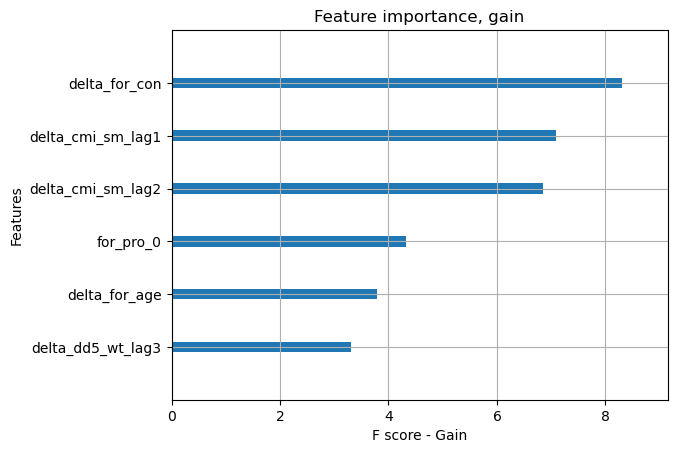

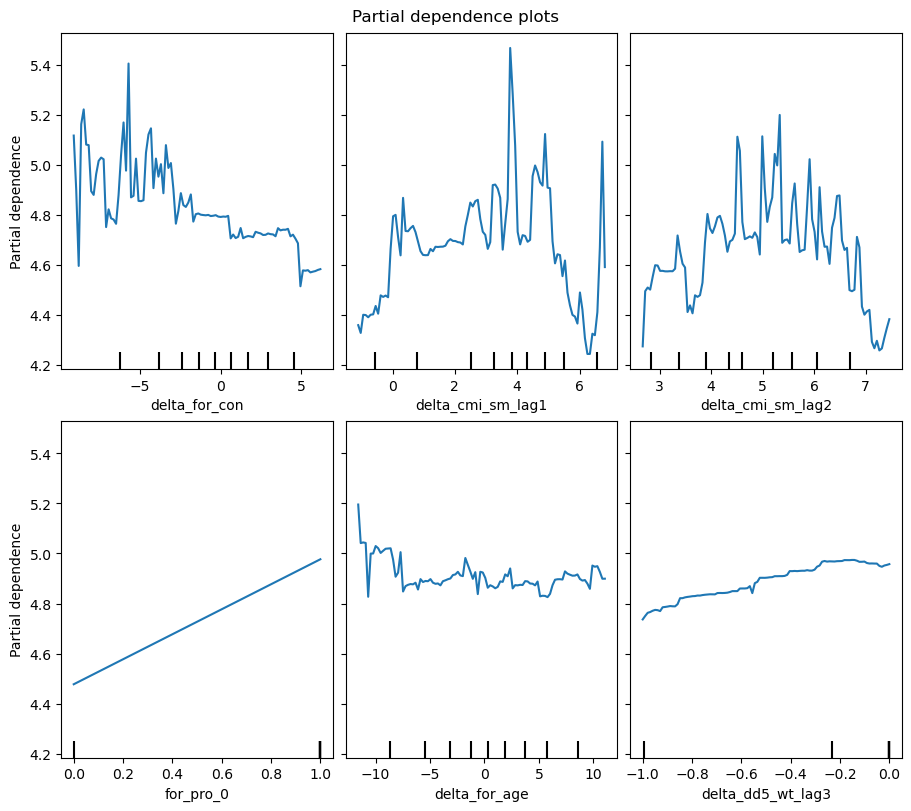

In [10]:
# loop version
#cols3 = ['for_con', 'cmi_sm', 'cmi_sm_lag1', 'cmi_sm_lag2', 'cmi_sm_lag3', 'dd5_wt_lag1', 'dd5_wt_lag3', 'for_age', 'for_pro_0']

cols2 = ['delta_dd5_wt_lag3', 'delta_cmi_sm_lag2', 'delta_cmi_sm_lag1', 'delta_for_age', 'delta_for_con','for_pro_0']

for z in range(len(dfall2)):
    list_of_vars = [[cols2]]
    for index, list in enumerate(list_of_vars):
        for x in list:
            #print(x)
            X1 = dfall2[z][x]
            #print(X1.describe())
            y1 = dfall2[z].iloc[:,6].abs()
            seed = 7 # random seed to help with replication
            testsize1 = 0.33 # percent of records to test after training
            x1_train, x1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=testsize1, random_state=seed) # Split data set. Note the 'stratify' option
            model_bp2 = XGBRegressor(base_score=None, booster=None, callbacks=None,
                 colsample_bylevel=None, colsample_bynode=None,
                 colsample_bytree=None, early_stopping_rounds=50,
                 enable_categorical=False, eval_metric=None, feature_types=None,
                 gamma=0.2, gpu_id=None, grow_policy=None, importance_type=None,
                 interaction_constraints=None, learning_rate=0.01, max_bin=None,
                 max_cat_threshold=None, max_cat_to_onehot=None,
                 max_delta_step=None, max_depth=8, max_leaves=None,
                 min_child_weight=None, missing=nan, monotone_constraints=None,
                 n_estimators=1000, n_jobs=None, num_parallel_tree=None,
                 predictor=None, random_state=42, reg_lambda=10, reg_alpha=1)
               # EVALUATION (with test)
            eval_set = [(x1_train, y1_train), (x1_test, y1_test)]
                #UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
            model_bp2.fit(x1_train, y1_train, eval_set=eval_set, verbose=False)
                # make predictions for test data
            y_pred = model_bp2.predict(x1_test)
            predictions = [round(value) for value in y_pred]
                # retrieve performance metrics
            results = model_bp2.evals_result()
            mse = mean_squared_error(y1_test, y_pred)
                #r2 = explained_variance_score(y1_test, ypred)
            r2 = r2_score(y1_test, y_pred)
                # adjusted R-squared
            adj_r2 = 1 - (((1-r2) * (len(y1_test)-1))/(len(y1_test)-x1_test.shape[1]-1))           
            
            # Feature importance plot
            xgb.plot_importance(model_bp2, ax=None, height=0.2, xlim=None, ylim=None, title='Feature importance, gain', 
                        xlabel='F score - Gain', ylabel='Features', 
                        importance_type='gain', max_num_features=15, grid=True, show_values=False) #, values_format='{v:.2f}' )

            pyplot.savefig(r'.\figs\version1\neg_gain_m{y}_v1.png'.format(y=len(x)),  dpi=300, bbox_inches='tight')
            #pyplot.show()
            
            # create lis of feature names to be used in dependency plot so that high ranking vars are plotted
            features_names1 = pd.DataFrame()
            features_names1['columns'] = X1.columns
            features_names1['importances'] = model_bp2.feature_importances_
            features_names1.sort_values(by='importances',ascending=False,inplace=True)
            features_names2 = features_names1['columns'].tolist()[0:10]

            # Partial dependence plots
            _, ax1 = plt.subplots(figsize=(9, 8), constrained_layout=True)

            display = PartialDependenceDisplay.from_estimator(model_bp2, x1_train, features_names2, ax=ax1)

            _ = display.figure_.suptitle(("Partial dependence plots"), fontsize=12, )

            pyplot.savefig(r'.\figs\version1\neg_partial_dep_m{y}_v1.png'.format(y=len(x)),  dpi=300, bbox_inches='tight')

            pyplot.show()


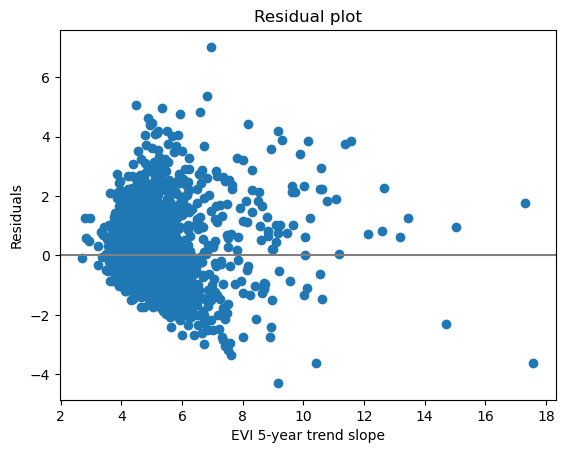

In [12]:
# Model prediction residuals

residuals = y1_test-y_pred

mean = residuals.mean()
std = residuals.std()

std_residuals = (residuals - mean)/std


pyplot.scatter(y_pred, std_residuals)

pyplot.ylabel('Residuals')
pyplot.xlabel("EVI 5-year trend slope")
pyplot.title('Residual plot')
pyplot.axhline(0, color="gray")

pyplot.show()

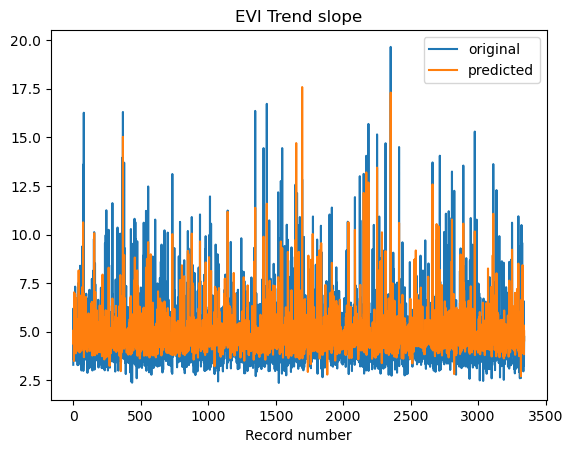

In [14]:
#import matplotlib.pyplot as plt

x_ax = range(len(y1_test))
pyplot.plot(x_ax, y1_test, label="original")
pyplot.plot(x_ax, y_pred, label="predicted")

pyplot.xlabel("Record number") # Order of observations/records in vector

pyplot.title("EVI Trend slope")

pyplot.legend()

pyplot.savefig(r'.\figs\version1\neg_predicted_m{y}_v1.png'.format(y=len(x)),  dpi=300, bbox_inches='tight')

pyplot.show()

In [66]:
# Plot tree. Use rankdir='LR' to make the plot show sideways
import graphviz

#fig, ax = pyplot.subplots(figsize=(8, 6)) #plt.figure(2, figsize=(8, 6))

format = 'png' #You should try the 'svg'

image = xgb.to_graphviz(model_bp2, num_trees = model_bp2.best_iteration) # best_iteration only works with early_stop_rounds

#Set a different dpi (works only if format == 'png')
image.graph_attr = {'dpi':'300'}

#image.render(r'.\figs\pos_decision_tree6.png', format = format)
image.render(r'.\figs\version5\neg_decision_tree_m{y}_v1.png'.format(y=len(x)), format = format)

#-#image

'figs\\version5\\neg_decision_tree_m9_v1.png.png'